In [1]:
# The following code is based on https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime

In [75]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df = pd.read_csv('../../output/descriptive_analysis.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df = df[61:427] # 1.6.2017 to 1.6.2018
df.index.freq = 'D'
df

,occupancy
dates,
2017-06-01,115
2017-06-02,113
2017-06-03,112
2017-06-04,117
2017-06-05,132
...,...
2018-05-28,103
2018-05-29,108
2018-05-30,104


In [3]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Occupancy')

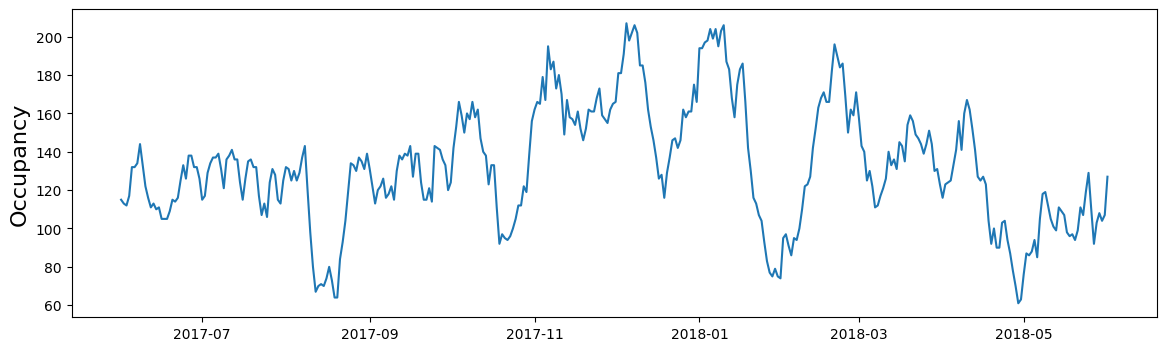

In [4]:
#plot
plt.figure(figsize=(14,4))
plt.plot(df)
plt.ylabel('Occupancy', fontsize=16)

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

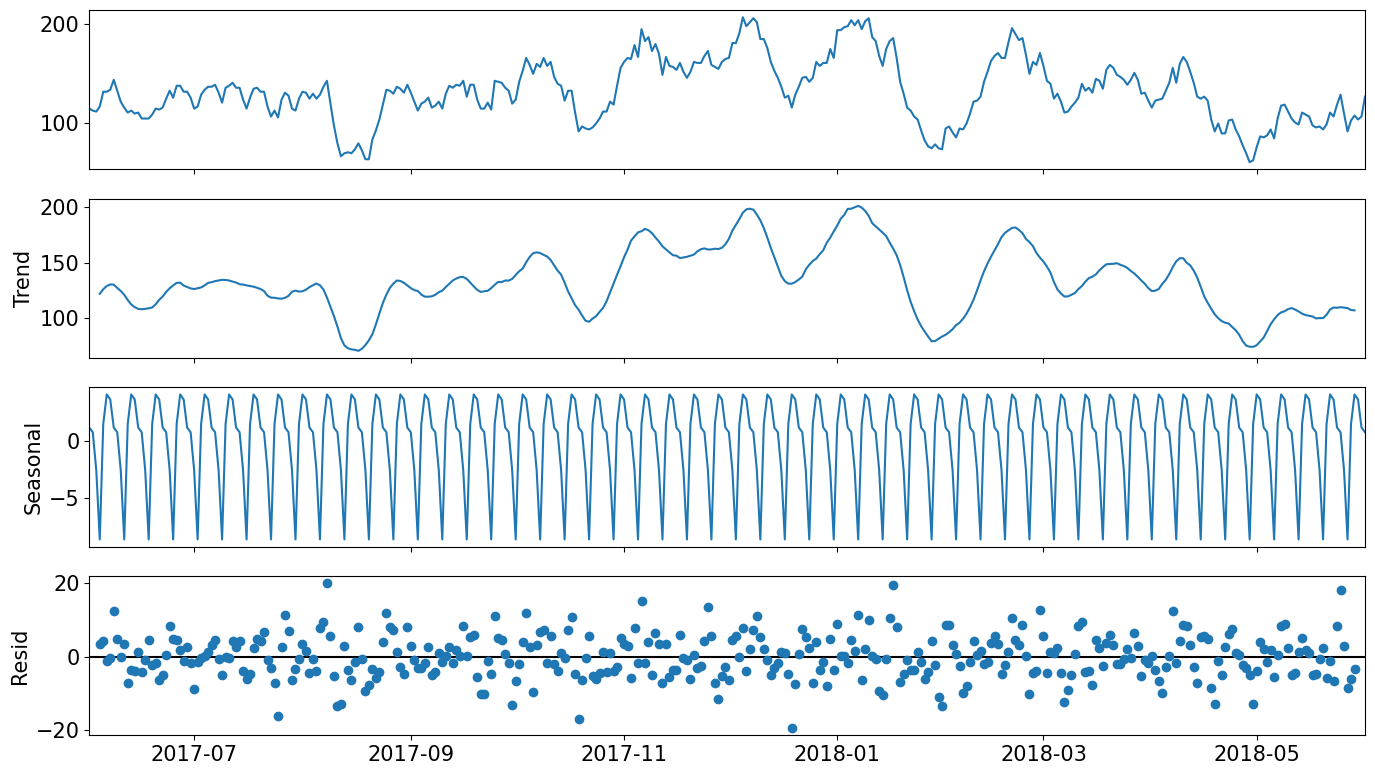

In [6]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df,model='additive')
fig = result.plot()

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

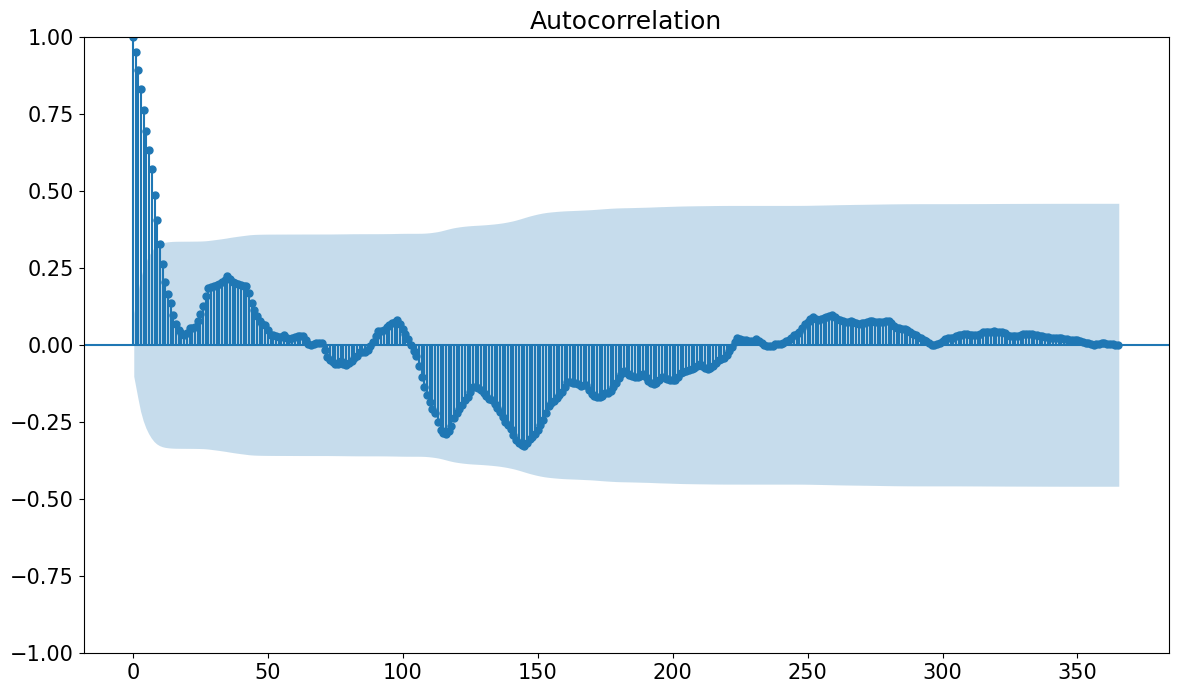

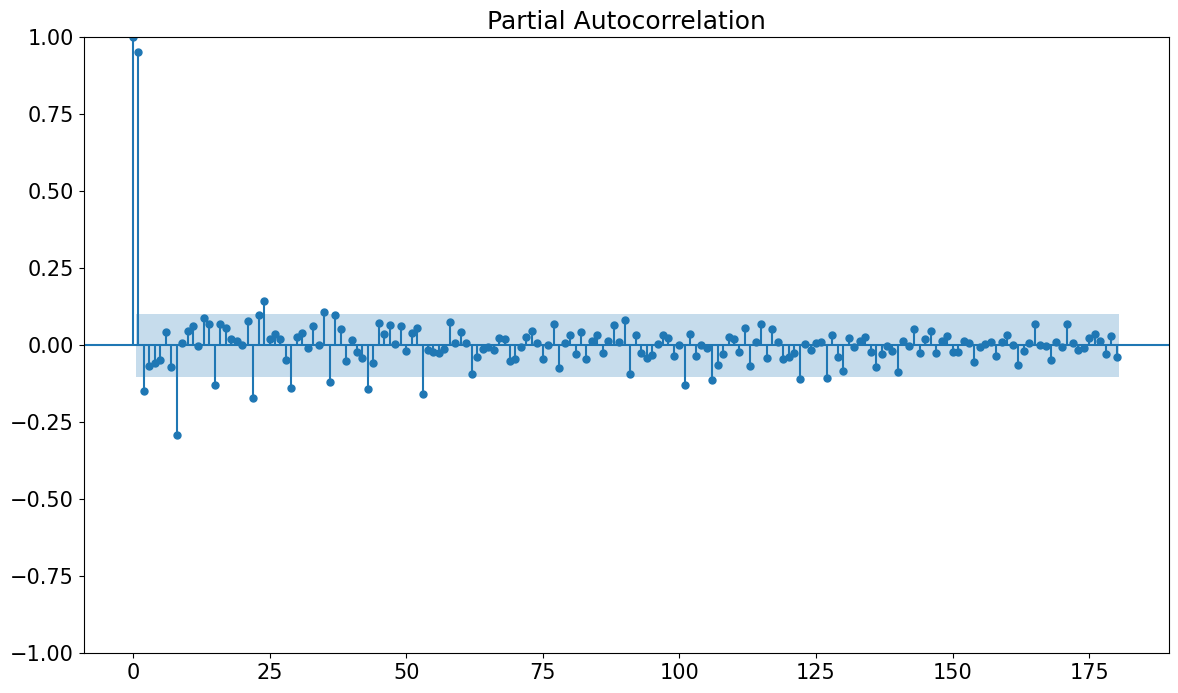

In [8]:
plot_acf(df['occupancy'], lags=365); # yearly pattern expected
plot_pacf(df['occupancy'], lags=180); # 300 because max value is 50% of data set

# No trend visible?
# Help: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
# dickey-fuller test
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['occupancy'])

The series is stationary


In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [16]:
p, d, q = 50, 0, 1# 50 because some form of trend, 0 because data is stationary?, q=10??

arima = ARIMA(df['occupancy'], order=(p,d,q)) 
model_fit = arima.fit()
predictions = arima.fit().predict()

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


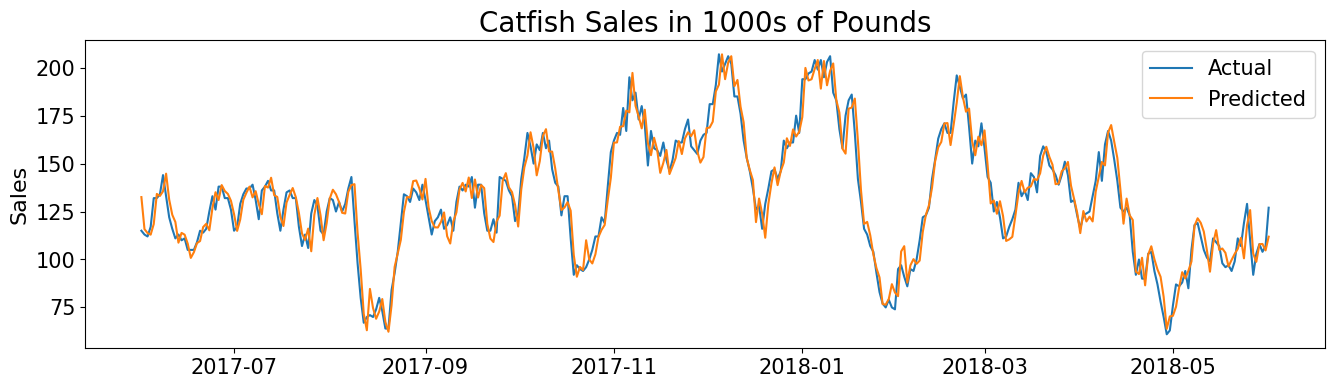

In [17]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [72]:
mse = mean_squared_error(df, predictions)
rmse = root_mean_squared_error(df, predictions)
mape = mean_absolute_percentage_error(df, predictions)
[mse, rmse, mape]

[60.857120997414434, 7.801097422633205, 0.050309470945949335]

In [34]:
# Generate forecasts for the next 10 time steps
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps) # 30 days into the future

forecast_index = pd.date_range(start=predictions.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame({'dates': forecast_index, 'predicted_mean': forecast})

# Combine the predictions and forecasted values into a single DataFrame
prediction_forecast = pd.concat([predictions, forecast_df.set_index('dates')], axis=0)
prediction_forecast

,predicted_mean
dates,
2017-06-01,132.534039
2017-06-02,115.835105
2017-06-03,113.773453
2017-06-04,112.936261
2017-06-05,118.475499
...,...
2018-06-27,115.365726
2018-06-28,114.608190
2018-06-29,119.279033


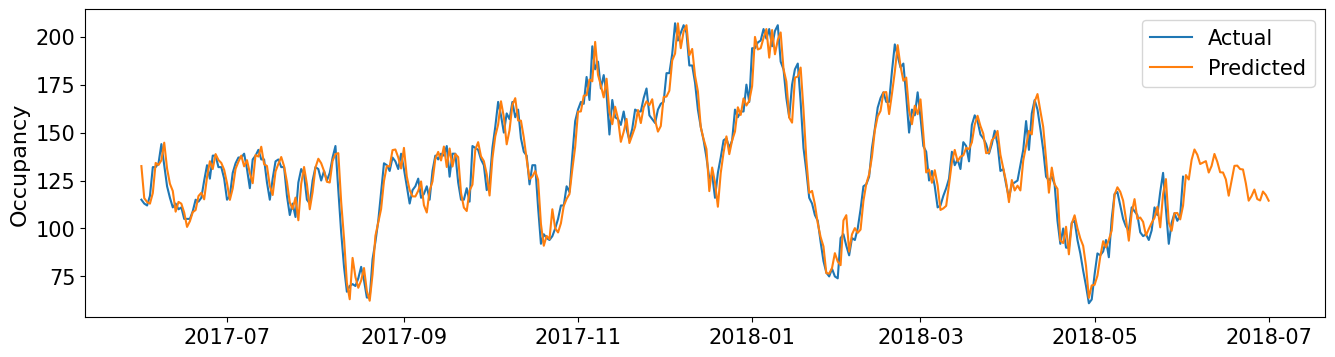

In [35]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(prediction_forecast, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [41]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [43]:
# SARIMA

sarima = SARIMAX(df['occupancy'],
                order=(1,0,1),
                seasonal_order=(1,0,1,50))
sarima_predictions = sarima.fit().predict()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00789D+00    |proj g|=  6.75670D-01

At iterate    5    f=  3.67451D+00    |proj g|=  3.66245D-03

At iterate   10    f=  3.67421D+00    |proj g|=  6.45827D-05

At iterate   15    f=  3.67419D+00    |proj g|=  1.99322D-03

At iterate   20    f=  3.67416D+00    |proj g|=  1.60412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   1.604D-05   3.674D+00
  F =   3.6741641555128877     

CONVERG

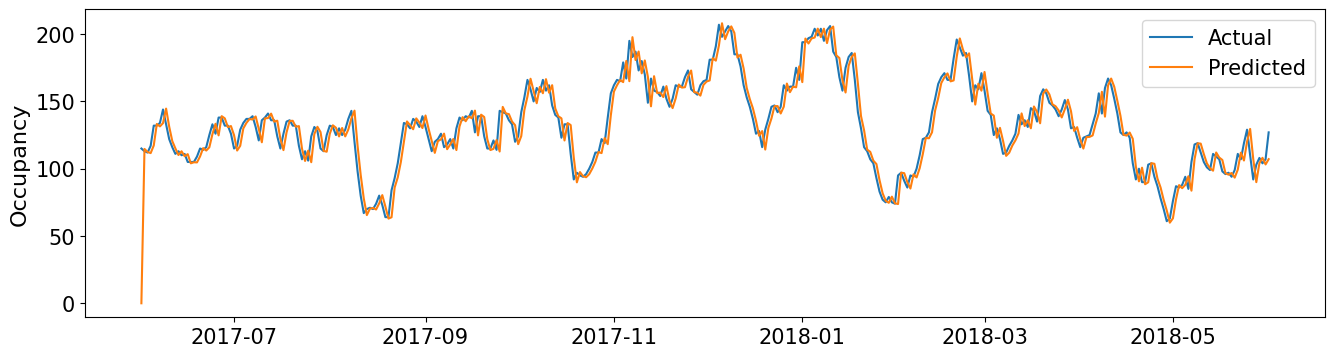

In [44]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(sarima_predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [76]:
mse = mean_squared_error(df, sarima_predictions)
rmse = root_mean_squared_error(df, sarima_predictions)
mape = mean_absolute_percentage_error(df, sarima_predictions)
[mse, rmse, mape]

[125.60943319205192, 11.207561429323148, 0.06156726314269769]

In [83]:
# Training

train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [89]:
p, d, q = 50, 0, 1# 50 because some form of trend, 0 because data is stationary?, q=10??
#p, d, q = 7, 0, 1

arima_train_data = ARIMA(train_data['occupancy'], order=(p,d,q))
model_fit_train_data = arima_train_data.fit()

# Generate forecasts for the next 10 time steps
forecast_steps = 30
forecast_train_data = model_fit_train_data.forecast(steps=forecast_steps) # 30 days into the future

/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


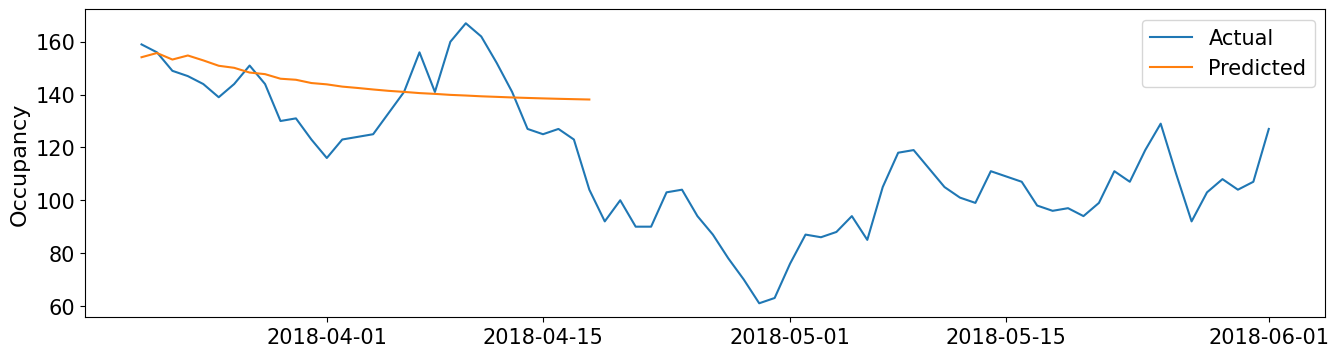

In [88]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [77]:
mse = mean_squared_error(test_data[:30], forecast_train_data)
rmse = root_mean_squared_error(test_data[:30], forecast_train_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[mse, rmse, mape]

[274.3869567418471, 16.564629689245912, 0.09286950246876066]

In [78]:
# Test until end of data
forecast_steps_whole_test_data = len(test_data)
forecast_train_data_whole_test_data = model_fit_train_data.forecast(steps=forecast_steps_whole_test_data) # 30 days into the future

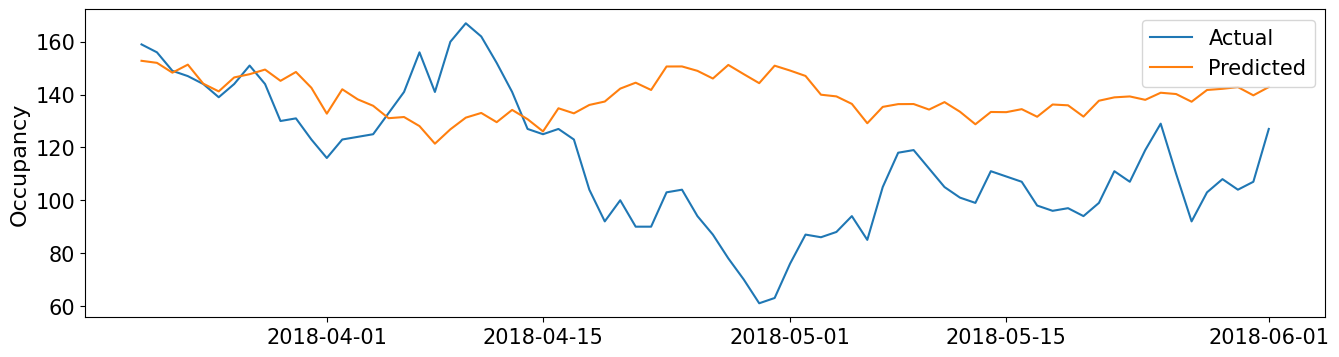

In [79]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data_whole_test_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [81]:
mse = mean_squared_error(test_data, forecast_train_data_whole_test_data)
rmse = root_mean_squared_error(test_data, forecast_train_data_whole_test_data)
mape = mean_absolute_percentage_error(test_data, forecast_train_data_whole_test_data)
[mse, rmse, mape]

[1322.761653506143, 36.369790396785945, 0.3125526123972648]